The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfull

# Multilayer Perceptrons
:label:`sec_mlp`

In :numref:`sec_softmax`, we introduced
softmax regression,
implementing the algorithm from scratch
(:numref:`sec_softmax_scratch`) and using high-level APIs
(:numref:`sec_softmax_concise`). This allowed us to
train classifiers capable of recognizing
10 categories of clothing from low-resolution images.
Along the way, we learned how to wrangle data,
coerce our outputs into a valid probability distribution,
apply an appropriate loss function,
and minimize it with respect to our model's parameters.
Now that we have mastered these mechanics
in the context of simple linear models,
we can launch our exploration of deep neural networks,
the comparatively rich class of models
with which this book is primarily concerned.


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

## Hidden Layers

We described affine transformations in
:numref:`subsec_linear_model` as
linear transformations with added bias.
To begin, recall the model architecture
corresponding to our softmax regression example,
illustrated in  :numref:`fig_softmaxreg`.
This model maps inputs directly to outputs
via a single affine transformation,
followed by a softmax operation.
If our labels truly were related
to the input data by a simple affine transformation,
then this approach would be sufficient.
However, linearity (in affine transformations) is a *strong* assumption.

### Limitations of Linear Models

For example, linearity implies the *weaker*
assumption of *monotonicity*, i.e.,
that any increase in our feature must
either always cause an increase in our model's output
(if the corresponding weight is positive),
or always cause a decrease in our model's output
(if the corresponding weight is negative).
Sometimes that makes sense.
For example, if we were trying to predict
whether an individual will repay a loan,
we might reasonably assume that all other things being equal,
an applicant with a higher income
would always be more likely to repay
than one with a lower income.
While monotonic, this relationship likely
is not linearly associated with the probability of
repayment. An increase in income from \$0 to \$50,000
likely corresponds to a bigger increase
in likelihood of repayment
than an increase from \$1 million to \$1.05 million.
One way to handle this might be to postprocess our outcome
such that linearity becomes more plausible,
by using the logistic map (and thus the logarithm of the probability of outcome).

Note that we can easily come up with examples
that violate monotonicity.
Say for example that we want to predict health as a function
of body temperature.
For individuals with a normal body temperature
above 37°C (98.6°F),
higher temperatures indicate greater risk.
However, if the body temperatures drops
below 37°C, lower temperatures indicate greater risk!
Again, we might resolve the problem
with some clever preprocessing, such as using the distance from 37°C
as a feature.


But what about classifying images of cats and dogs?
Should increasing the intensity
of the pixel at location (13, 17)
always increase (or always decrease)
the likelihood that the image depicts a dog?
Reliance on a linear model corresponds to the implicit
assumption that the only requirement
for differentiating cats and dogs is to assess
the brightness of individual pixels.
This approach is doomed to fail in a world
where inverting an image preserves the category.

And yet despite the apparent absurdity of linearity here,
as compared with our previous examples,
it is less obvious that we could address the problem
with a simple preprocessing fix.
That is, because the significance of any pixel
depends in complex ways on its context
(the values of the surrounding pixels).
While there might exist a representation of our data
that would take into account
the relevant interactions among our features,
on top of which a linear model would be suitable,
we simply do not know how to calculate it by hand.
With deep neural networks, we used observational data
to jointly learn both a representation via hidden layers
and a linear predictor that acts upon that representation.

This problem of nonlinearity has been studied for at least a
century :cite:`Fisher.1928`. For instance, decision trees
in their most basic form use a sequence of binary decisions to
decide upon class membership :cite:`quinlan2014c4`. Likewise, kernel
methods have been used for many decades to model nonlinear dependencies
:cite:`Aronszajn.1950`. This has found its way into
nonparametric spline models :cite:`Wahba.1990` and kernel methods
:cite:`Scholkopf.Smola.2002`. It is also something that the brain solves
quite naturally. After all, neurons feed into other neurons which,
in turn, feed into other neurons again :cite:`Cajal.Azoulay.1894`.
Consequently we have a sequence of relatively simple transformations.

### Incorporating Hidden Layers

We can overcome the limitations of linear models
by incorporating one or more hidden layers.
The easiest way to do this is to stack
many fully connected layers on top of one another.
Each layer feeds into the layer above it,
until we generate outputs.
We can think of the first $L-1$ layers
as our representation and the final layer
as our linear predictor.
This architecture is commonly called
a *multilayer perceptron*,
often abbreviated as *MLP* (:numref:`fig_mlp`).

![An MLP with a hidden layer of five hidden units.](http://d2l.ai/_images/mlp.svg)
:label:`fig_mlp`

This MLP has four inputs, three outputs,
and its hidden layer contains five hidden units.
Since the input layer does not involve any calculations,
producing outputs with this network
requires implementing the computations
for both the hidden and output layers;
thus, the number of layers in this MLP is two.
Note that both layers are fully connected.
Every input influences every neuron in the hidden layer,
and each of these in turn influences
every neuron in the output layer. Alas, we are not quite
done yet.

### From Linear to Nonlinear

As before, we denote by the matrix $\mathbf{X} \in \mathbb{R}^{n \times d}$
a minibatch of $n$ examples where each example has $d$ inputs (features).
For a one-hidden-layer MLP whose hidden layer has $h$ hidden units,
we denote by $\mathbf{H} \in \mathbb{R}^{n \times h}$
the outputs of the hidden layer, which are
*hidden representations*.
Since the hidden and output layers are both fully connected,
we have hidden-layer weights $\mathbf{W}^{(1)} \in \mathbb{R}^{d \times h}$ and biases $\mathbf{b}^{(1)} \in \mathbb{R}^{1 \times h}$
and output-layer weights $\mathbf{W}^{(2)} \in \mathbb{R}^{h \times q}$ and biases $\mathbf{b}^{(2)} \in \mathbb{R}^{1 \times q}$.
This allows us to calculate the outputs $\mathbf{O} \in \mathbb{R}^{n \times q}$
of the one-hidden-layer MLP as follows:

$$
\begin{aligned}
    \mathbf{H} & = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}, \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.
\end{aligned}
$$

Note that after adding the hidden layer,
our model now requires us to track and update
additional sets of parameters.
So what have we gained in exchange?
You might be surprised to find out
that---in the model defined above---*we
gain nothing for our troubles*!
The reason is plain.
The hidden units above are given by
an affine function of the inputs,
and the outputs (pre-softmax) are just
an affine function of the hidden units.
An affine function of an affine function
is itself an affine function.
Moreover, our linear model was already
capable of representing any affine function.

To see this formally we can just collapse out the hidden layer in the above definition,
yielding an equivalent single-layer model with parameters
$\mathbf{W} = \mathbf{W}^{(1)}\mathbf{W}^{(2)}$ and $\mathbf{b} = \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)}$:

$$
\mathbf{O} = (\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})\mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W} + \mathbf{b}.
$$

In order to realize the potential of multilayer architectures,
we need one more key ingredient: a
nonlinear *activation function* $\sigma$
to be applied to each hidden unit
following the affine transformation. For instance, a popular
choice is the ReLU (rectified linear unit) activation function :cite:`Nair.Hinton.2010`
$\sigma(x) = \mathrm{max}(0, x)$ operating on its arguments elementwise.
The outputs of activation functions $\sigma(\cdot)$
are called *activations*.
In general, with activation functions in place,
it is no longer possible to collapse our MLP into a linear model:

$$
\begin{aligned}
    \mathbf{H} & = \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}), \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.\\
\end{aligned}
$$

Since each row in $\mathbf{X}$ corresponds to an example in the minibatch,
with some abuse of notation, we define the nonlinearity
$\sigma$ to apply to its inputs in a rowwise fashion,
i.e., one example at a time.
Note that we used the same notation for softmax
when we denoted a rowwise operation in :numref:`subsec_softmax_vectorization`.
Quite frequently the activation functions we use apply not merely rowwise but
elementwise. That means that after computing the linear portion of the layer,
we can calculate each activation
without looking at the values taken by the other hidden units.

To build more general MLPs, we can continue stacking
such hidden layers,
e.g., $\mathbf{H}^{(1)} = \sigma_1(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})$
and $\mathbf{H}^{(2)} = \sigma_2(\mathbf{H}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)})$,
one atop another, yielding ever more expressive models.

### Universal Approximators

We know that the brain is capable of very sophisticated statistical analysis. As such,
it is worth asking, just *how powerful* a deep network could be. This question
has been answered multiple times, e.g., in :citet:`Cybenko.1989` in the context
of MLPs, and in :citet:`micchelli1984interpolation` in the context of reproducing kernel
Hilbert spaces in a way that could be seen as radial basis function (RBF) networks with a single hidden layer.
These (and related results) suggest that even with a single-hidden-layer network,
given enough nodes (possibly absurdly many),
and the right set of weights,
we can model any function.
Actually learning that function is the hard part, though.
You might think of your neural network
as being a bit like the C programming language.
The language, like any other modern language,
is capable of expressing any computable program.
But actually coming up with a program
that meets your specifications is the hard part.

Moreover, just because a single-hidden-layer network
*can* learn any function
does not mean that you should try
to solve all of your problems
with one. In fact, in this case kernel methods
are way more effective, since they are capable of solving the problem
*exactly* even in infinite dimensional spaces :cite:`Kimeldorf.Wahba.1971,Scholkopf.Herbrich.Smola.2001`.
In fact, we can approximate many functions
much more compactly by using deeper (rather than wider) networks :cite:`Simonyan.Zisserman.2014`.
We will touch upon more rigorous arguments in subsequent chapters.


## Activation Functions
:label:`subsec_activation-functions`

Activation functions decide whether a neuron should be activated or not by
calculating the weighted sum and further adding bias to it.
They are differentiable operators for transforming input signals to outputs,
while most of them add nonlinearity.
Because activation functions are fundamental to deep learning,
(**let's briefly survey some common ones**).

### ReLU Function

The most popular choice,
due to both simplicity of implementation and
its good performance on a variety of predictive tasks,
is the *rectified linear unit* (*ReLU*) :cite:`Nair.Hinton.2010`.
[**ReLU provides a very simple nonlinear transformation**].
Given an element $x$, the function is defined
as the maximum of that element and $0$:

$$\operatorname{ReLU}(x) = \max(x, 0).$$

Informally, the ReLU function retains only positive
elements and discards all negative elements
by setting the corresponding activations to 0.
To gain some intuition, we can plot the function.
As you can see, the activation function is piecewise linear.


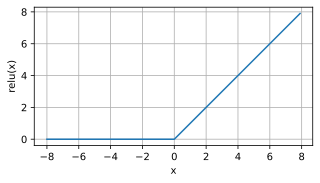

In [9]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

When the input is negative,
the derivative of the ReLU function is 0,
and when the input is positive,
the derivative of the ReLU function is 1.
Note that the ReLU function is not differentiable
when the input takes value precisely equal to 0.
In these cases, we default to the left-hand-side
derivative and say that the derivative is 0 when the input is 0.
We can get away with this because
the input may never actually be zero (mathematicians would
say that it is nondifferentiable on a set of measure zero).
There is an old adage that if subtle boundary conditions matter,
we are probably doing (*real*) mathematics, not engineering.
That conventional wisdom may apply here, or at least, the fact that
we are not performing constrained optimization :cite:`Mangasarian.1965,Rockafellar.1970`.
We plot the derivative of the ReLU function below.


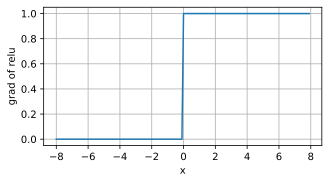

In [10]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

The reason for using ReLU is that
its derivatives are particularly well behaved:
either they vanish or they just let the argument through.
This makes optimization better behaved
and it mitigated the well-documented problem
of vanishing gradients that plagued
previous versions of neural networks (more on this later).

Note that there are many variants to the ReLU function,
including the *parametrized ReLU* (*pReLU*) function :cite:`He.Zhang.Ren.ea.2015`.
This variation adds a linear term to ReLU,
so some information still gets through,
even when the argument is negative:

$$\operatorname{pReLU}(x) = \max(0, x) + \alpha \min(0, x).$$

### Sigmoid Function

[**The *sigmoid function* transforms those inputs**]
whose values lie in the domain $\mathbb{R}$,
(**to outputs that lie on the interval (0, 1).**)
For that reason, the sigmoid is
often called a *squashing function*:
it squashes any input in the range (-inf, inf)
to some value in the range (0, 1):

$$\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$

In the earliest neural networks, scientists
were interested in modeling biological neurons
that either *fire* or *do not fire*.
Thus the pioneers of this field,
going all the way back to McCulloch and Pitts,
the inventors of the artificial neuron,
focused on thresholding units :cite:`McCulloch.Pitts.1943`.
A thresholding activation takes value 0
when its input is below some threshold
and value 1 when the input exceeds the threshold.

When attention shifted to gradient-based learning,
the sigmoid function was a natural choice
because it is a smooth, differentiable
approximation to a thresholding unit.
Sigmoids are still widely used as
activation functions on the output units
when we want to interpret the outputs as probabilities
for binary classification problems: you can think of the sigmoid as a special case of the softmax.
However, the sigmoid has largely been replaced
by the simpler and more easily trainable ReLU
for most use in hidden layers. Much of this has to do
with the fact that the sigmoid poses challenges for optimization
:cite:`LeCun.Bottou.Orr.ea.1998` since its gradient vanishes for large positive *and* negative arguments.
This can lead to plateaus that are difficult to escape from.
Nonetheless sigmoids are important. In later chapters (e.g., :numref:`sec_lstm`) on recurrent neural networks,
we will describe architectures that leverage sigmoid units
to control the flow of information across time.

Below, we plot the sigmoid function.
Note that when the input is close to 0,
the sigmoid function approaches
a linear transformation.


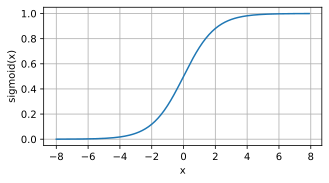

In [11]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

The derivative of the sigmoid function is given by the following equation:

$$\frac{d}{dx} \operatorname{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \operatorname{sigmoid}(x)\left(1-\operatorname{sigmoid}(x)\right).$$


The derivative of the sigmoid function is plotted below.
Note that when the input is 0,
the derivative of the sigmoid function
reaches a maximum of 0.25.
As the input diverges from 0 in either direction,
the derivative approaches 0.


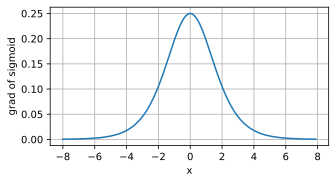

In [12]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

### Tanh Function
:label:`subsec_tanh`

Like the sigmoid function, [**the tanh (hyperbolic tangent)
function also squashes its inputs**],
transforming them into elements on the interval (**between $-1$ and $1$**):

$$\operatorname{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$

We plot the tanh function below. Note that as input nears 0, the tanh function approaches a linear transformation. Although the shape of the function is similar to that of the sigmoid function, the tanh function exhibits point symmetry about the origin of the coordinate system :cite:`Kalman.Kwasny.1992`.


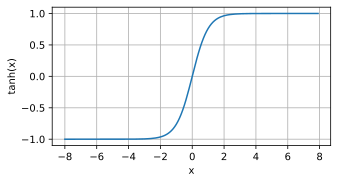

In [13]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

The derivative of the tanh function is:

$$\frac{d}{dx} \operatorname{tanh}(x) = 1 - \operatorname{tanh}^2(x).$$

It is plotted below.
As the input nears 0,
the derivative of the tanh function approaches a maximum of 1.
And as we saw with the sigmoid function,
as input moves away from 0 in either direction,
the derivative of the tanh function approaches 0.


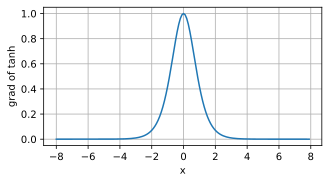

In [14]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

## Summary and Discussion

We now know how to incorporate nonlinearities
to build expressive multilayer neural network architectures.
As a side note, your knowledge already
puts you in command of a similar toolkit
to a practitioner circa 1990.
In some ways, you have an advantage
over anyone working back then,
because you can leverage powerful
open-source deep learning frameworks
to build models rapidly, using only a few lines of code.
Previously, training these networks
required researchers to code up layers and derivatives
explicitly in C, Fortran, or even Lisp (in the case of LeNet).

A secondary benefit is that ReLU is significantly more amenable to
optimization than the sigmoid or the tanh function. One could argue
that this was one of the key innovations that helped the resurgence
of deep learning over the past decade. Note, though, that research in
activation functions has not stopped.
For instance,
the GELU (Gaussian error linear unit)
activation function $x \Phi(x)$ by :citet:`Hendrycks.Gimpel.2016` ($\Phi(x)$
is the standard Gaussian cumulative distribution function)
and
the Swish activation
function $\sigma(x) = x \operatorname{sigmoid}(\beta x)$ as proposed in :citet:`Ramachandran.Zoph.Le.2017` can yield better accuracy
in many cases.

## Exercises

1. Show that adding layers to a *linear* deep network, i.e., a network without
   nonlinearity $\sigma$ can never increase the expressive power of the network.
   Give an example where it actively reduces it.
1. Compute the derivative of the pReLU activation function.
1. Compute the derivative of the Swish activation function $x \operatorname{sigmoid}(\beta x)$.
1. Show that an MLP using only ReLU (or pReLU) constructs a
   continuous piecewise linear function.
1. Sigmoid and tanh are very similar.
    1. Show that $\operatorname{tanh}(x) + 1 = 2 \operatorname{sigmoid}(2x)$.
    1. Prove that the function classes parametrized by both nonlinearities are identical. Hint: affine layers have bias terms, too.
1. Assume that we have a nonlinearity that applies to one minibatch at a time, such as the batch normalization :cite:`Ioffe.Szegedy.2015`. What kinds of problems do you expect this to cause?
1. Provide an example where the gradients vanish for the sigmoid activation function.


[Discussions](https://discuss.d2l.ai/t/91)


### Notes:

Hidden layers:

For single layer networks, there are only affine transformations, or a linear transformation and a bias. This works fine if your features all directly relate to your outputs by a simple affine transformation, but this assumption only holds for very simple problems, and linearity is a strong assumption.



Limitations of Linear Models:

Linear models have the weak assumption of monotonicity, or that any increase in a feature causes an increase in output, and vice versa (and obviously this inverts if the weight is negative). This means that for something like modeling whether a person will pay back a loan, you will run into issues. Assuming all other variables are fixed, a linear increase in income doesn't mean a linear increase in whether they will pay it back. This feature probably increases likelihood logarithmically rather than linearly. Of course, we can correct this afterwards by having a logarithmic function that augments the output of the weight for that feature too. However, this requires manual augmentation of the model, and isn't applicable in all cases. For example, image recognition. Because linear models have each feature as independent (which doesn't hold in reality, as pixel values are heavily correlated with surrounding ones), you can train a model to predict images. But if you invert the pixel values, even though any person would have no issue dealing with it, a linear model would just completely break down. So, having a deep neural network allows the hidden layers to learn the representations, and linear predictors to act on these representations, avoiding this problem. Methods to deal with the inherent flaws of linear models include decision trees (binary decision making) and kernel methods. So, by stacking layers of simple transformations, models can deal with nonlinearity.


Incorporating hidden layers:

The easiest way to build a nonlinear capable model is just to stack multiple fully connected layers. So for a model with 4 input features, 1 hidden layer of 5 neurons, and an output layer of 3 neurons, we have layer_count - 1 layers that are the representations, and the final layer is the linear predictor. The input layer doesn't count, because there is no computation being done there. Because it is fully connected, each input influences every output in the next layer. However, we still have to do more to make the model represent nonlinear behaviours.


From Linear to Nonlinear:

You can't just stack multiple layers and get nonlinear capability.

Lets use the same 3 layer mlp as before.

X = minibatch. R^n * p  (where n is sample count, p is feature count)

W_1 = weights of hidden layer 1. R^p * h (where h is amount of neurons of the hidden layer)

b_1 = bias of hidden layer 1. R^1 * h

H = output of hidden layer. R^n * h

W_2 = weights of output layer. R^d * q (where q is amount of output neurons)

O = outputs. R^n * q


So, our current model does:

H = XW_1 + b_1

O = HW_2 + b_2

However, this is still linear. This is because an affine transformation on top of any amount of any affine transformations is capable of being expressed as a single affine transformation.


So, if we let W = W_1*W_2, and b = b_1W_2 + b_2:

We can expand what our model does:

O = XW_1W_2 + b_1W_2 + b_2

Which is just:

O = XW + b


So without any introduced nonlinearity, a multiple layer neural network has zero different from a single layer linear network.

This means we have to introduce nonlinearity. an example of this is ReLU:
σ(x) = max(0, x)

This is an elementwise operation on the arguments. We call the outputs of nonlinearity activations.

Our model now becomes:

H = σ(XW_1 + b_1)

O = HW_2 + b_2

Notation is used technically off here, as it is defined to apply rowwise, so an example at a time.

It is obvious why adding a nonlinearity makes the model capable of expressing nonlinear functions. Because ReLU takes the max of the argument and 0, all negative arguments become zero. So, the function is no longer monotonic. This means not every feature has to contribute. Because the model can learn weights to make a feature negative, which would mean that it has certain inputs for that will not lead to an output. So it can turn certain activatioins off, increasing sparsity. Hidden layers can be stacked ontop of eachother, increasing the expressiveness of the model.


Universal Representations:

Technically speaking, you can model any function with a single hidden layer mlp (given enough nodes, of course). However, there are practical reasons for why this is a bad idea. One reason is just that kernel methods exist, and they solve problems exactly even in infinite dimensions. As such, we can increase the depth of our network to not have to have a massive single hidden layer mlp.


Activation Functions:

Activation functions further add a bias after the weighted sum of a neuron, and decide whether it should fire or not. Here are some common ones:


ReLU:

ReLU(x) = max(0, x)


What this means is that all positive values remain the same, while negative values all become zero. This means that only neurons with a positive weighted sum can fire. ReLU is good because the derivatives are very simple, 0 for all negatives, and 1 for all positives. There isn't a derivative for 0, so it is just treated as the lhs derivative of 0. Because of how simple the derivative is, this makes computing the gradient very simple. Because the derivatives of ReLU are "well behaved" (they either completely disappear or let the argument through), this makes optimization with ReLU very easy, and solved the problem of vanishing gradients.

There are ReLU variants like pReLU, which add a linear term to ReLU, so that negative arguments still give some information:

ReLU(x) = max(0, x) + α * min(0,x)


Sigmoid:

Sigmoid turns values in domain R to lie in the interval (0, 1). This is why it is called a squashing function, because it "sqaushes" all reals into said interval.

Sigmoid(x) = 1/(1 + exp(-x))

Sigmoid became widely used when the focus turned from binary activation (where all activations are either 0 or 1), to gradient based methods, because it is smooth and differentiable approximation of a thresholding unit. Sigmoids are commonly used for binary classification problems, because it is essentially a special case of softmax (which is good for binary classification for obvious reasons). While sigmoid has these advantages over ReLU, ReLU is still more widely used for hidden layers, because sigmoid deals with the issue of vanishing gradients.

The derivative of sigmoid is sigmoid(x)(1 - sigmoid(x)). (Wow its the variance of a bernoulli random variable).

As such, the max value of the derivative of the sigmoid is 0.25. The minimum value of the sigmoid is 0. So, as x gets very large or small, sigmoid approaches 1 or 0 respectively. As it levels off in these regions, the gradients become increasingly flatter. And as gradients are multiplied during backprop, and these gradients are tiny (very often less than 1), this means that after just a few layers the gradients become extremely small. However, sigmoid still has uses such as controlling information flow over time in lstms.


Tanh:

Tanh, or the hyperbolic tangent, does the same thing as sigmoid, where it squashes inputs, but into the interval of (-1, 1). The difference with sigmoid is that it is symmetric about the origin, and can have both positive and negative outputs.

tanh(x) = (1 - exp(-2x))/(1 + exp(-2x))

Tanh also becomes approaches a linear transformation as the input approaches 0.

The derivative of tanh is 1 - tanh(x)^2

This is similar to the derivative of the sigmoid, but it is bounded between 1 and 0.

Tanh still faces the same vanishing gradients effect that sigmoid does, but it is better. This is because tanh is symmetric about the x axis. Because sigmoid only returns positive values, that means the gradient is often all positive or negative with respect to the weights. This causes descent to oscillate more, as the weight values still span both positive and negative values. However, as tanh is centered around 0, it is far more balanced, so it is far more likely that some gradients are positive and some are negative with respect to the weights, which makes the updates more balanced and speeds up convergence.


### Exercises:

1.

Proved above.
You can't just stack multiple layers and get nonlinear capability.
Lets use the same 3 layer mlp as before.
X = minibatch. R^n*p  (where n is sample count, p is feature count)
W_1 = weights of hidden layer. R^p*h (where h is amount of neurons of the hidden layer)
b_1 = bias of hidden layer. R^1*h
H = output of hidden layer. R^n*h
W_2 = weights of output layer. R^h*q (where q is amount of output neurons)
b_1 = bias of hidden layer. R^1*q
O = outputs. R^n*q

So, our current model does:
H = XW_1 + b_1
O = HW_2 + b_2

However, this is still linear. This is because an affine transformation ontop of any amount of any affine transformations is capable of being expressed as a single affine transformation.

So, if we let W = W_1*W_2, and b = b_1W_2 + b_2:
We can expand what our model does:
O = XW_1W_2 + b_1W_2 + b_2

Which is just:
O = XW + b

This is true for any amount of linear layers, because multiplying an affine function by an affine function is still an affine function.

Since these are purely linear, the rank (dimensionality) of a single layer neural networks smallest layer determines the matrix it can realize up to. So, a single layer network with input of 10 and output of 5 can realize up to a rank 5 matrix. If we add a single hidden layer, which is rank 3, it can only realize a matrix of up to rank 3. Because you lose expressiveness from the input to the hidden layer, and you can't get it back.


2. Compute the derivative of the pReLU activation function.


Case 1: x is positive:

pReLU(x) = max(0, x) + α * min (0, x)

derivative = 1 + 0 = 1


Case 2: x is 0:

pReLU(x) = max(0, x) + α * min (0, x)

We default to the lhs derivative (which is α for pReLU), as it isn't differentiable at x = 0.

derivative = α


Case 3: x is negative:

pReLU(x) = max(0, x) + α * min (0, x)

derivative = 0 + α * (1) = α



3. Compute the derivative of the Swish activation function x * sigmoid(βx)

Swish = x * sigmoid(βx)

Swish =  x * 1/(1+exp(-βx))

a = x, b = 1/(1+exp(-βx))

derivative = a'b + ab'

derivative = sigmoid(βx) + x * β * sigmoid(βx)(1 - sigmoid(βx))



4. Show that an MLP using only ReLU (or pReLU) constructs a continuous piecewise linear function.


ReLU(x) = max(0, x)

H = σ(XW_1 + b_1)
O = HW_2 + b_2

As all inputs to ReLU remain the same when they are positive, and are 0 otherwise:

XW_1 + b_1 -> XW_1 + b_1 while x > 0

This clearly shows that the subfunction of the function that remains is all positive values of XW_1 + b_1, which is indeed piecewise and continous.


Assume the first hidden layer has 2 ReLUs (so 2 neurons), w_1, w_2 of R^2, and biases b_1, b_2:

z_i = xw_i + b_i

h_i(x) = ReLU(0, z_i(x))

H(x) = [h_1(x), h_2(x))]

We have 4 patterns:

Both on:

H(x) = [z_1(x), z_2(x))]

Only neuron 1 on:

H(x) = [z_1(x), 0]

Only neuron 2 on:

H(x) = [0, z_2(x)]

Both off:

H(x) = [0, 0]

So, clearly all of these are affine, with 4 total cases.


Now assume the next layer also has 2 neurons, so weights w_3, w_4 of R^2, and biases b_3, b_4:

d_j(x) = Hw_i + b_i

o_j(x) = ReLU(0, d_j(x))

O(x) = [o_1(x), o_2(x)]


So we have the cases:

Both on:

O(x) = [o_1(x), o_2(x)]

Only neuron 3 on:

O(x) = [o_1(x), 0]

Only neuron 4 on:

O(x) = [0, o_2(x)]

Both off:

O(x) = [0, 0]


For example:

Ax + c

O(x) = [o_1(x), 0]

w_3Ux + w_3v + b_3

w_3U = A, w_3v + b_3 = c


Once again, the reason it is affine is obvious. Sums of affine functions are just affine functions, and since all functions are in terms of the inputs, it is affine in terms of x. However, these obviously are the higher level cases only. For each case, of O(x), we also have all cases of H(x) as possible, so there are 16 total possible cases.



5. Sigmoid and tanh are very similar.

5.1 Show that tanh(x) + 1 = 2sigmoid(2x)

tanh = (1 - exp(-2x))/(1 + exp(-2x))

tanh + 1 = (1 - exp(-2x))/(1 + exp(-2x)) + (1 + exp(-2x))/(1 + exp(-2x))

tanh + 1 = (1 - exp(-2x) + 1 + exp(-2x))/(1 + exp(-2x))

tanh + 1 = 2/(1 + exp(-2x)


sigmoid(x) = 1/(1 + exp(-x))

2sigmoid(2x) = 2/(1+ + exp(-2x)


So it is clear that tanh + 1 = 2sigmoid(2x)


5.2 Prove that the function classes parametrized by both nonlinearities are identical. Hint: affine layers have bias terms, too.



In section 1 we have proved that tanh + 1 = 2sigmoid(2x)

We can rearrange to get tanh = 2sigmoid(2x) - 1

So, we can create tanh through multiplying sigmoid by a constant, and adding another constant. As such, these are reversible operations. We simply for one of the functions use a bias that is off by one, and scale our weights linearly (which is literally what an affine function does), and then the two functions will be exactly the same after tanh or sigmoid


6. Assume that we have a nonlinearity that applies to one minibatch at a time, such as the batch normalization (Ioffe and Szegedy, 2015). What kinds of problems do you expect this to cause?

What batch normalization does is normalize the inputs to layer(s) based off of the statistics of the minibatch, to push the inputs to have a mean of zero and standard deviation of one. What I assume this does is make it so that the observed fisher matrix is invertible (seems kinda similar to muon to me, where pushing the matrix to be invertible essentially restores fullrank of the minibatch which is obviously a good thing)? It seems to clearly be helpful and a good thing, as inputs should be relative to their feature, not absolute (which I assume is the case when inputs aren't normalized), and you want to treat them on the same scale so that features with inherently large values don't just dominate updates to gradients.

Given that one of the main benefits in training is that you can use a higher learning rate (as you don't have to worry about a batch with larger updates exploding the gradient updates), I assume a problem is the potential for exploding gradients and divergence simply due to the fact that higher learning rates are used.